In [1]:
import sys

In [2]:
!{sys.executable} -m pip install --upgrade pip --trusted-host pypi.org --trusted-host files.pythonhosted.org
!{sys.executable} -m pip install https://download.pytorch.org/whl/cpu/torchvision-0.4.2%2Bcpu-cp36-cp36m-linux_x86_64.whl
!{sys.executable} -m pip install https://s3.amazonaws.com/amazonei-pytorch/torch_eia-1.3.1-cp36-cp36m-manylinux1_x86_64.whl

!{sys.executable} -m pip install graphviz==0.13.2   
!{sys.executable} -m pip install mxnet-model-server==1.0.8
!{sys.executable} -m pip install pillow==7.1.0
!{sys.executable} -m pip install sagemaker_containers
!{sys.executable} -m pip install -U sagemaker

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages (20.1.1)


Requirement already up-to-date: sagemaker in /home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages (1.70.2)


In [3]:
from PIL import Image
from sagemaker import get_execution_role
from sagemaker import predictor

import src_dir.util as util

import os
import boto3
import time
import subprocess
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.distributed as dist
from PIL import Image
from torchvision import transforms, models
import sagemaker

In [4]:
%store -r

In [5]:
role = get_execution_role()

## 1.Trace_model 생성

In [6]:
model = util.torch_model(hyperparameters['model_name'])

=> using pre-trained model 'wide_resnet50_2'


In [7]:
%store -r model_dir

In [8]:
multigpus_distributed = True

In [9]:
## multigpus_distributed
if multigpus_distributed:
    model = torch.nn.DataParallel(model)
with open(os.path.join(model_dir, 'model_best.pth'), 'rb') as f:
    model_load = torch.load(f, map_location=torch.device('cpu'))
    class_to_idx = model_load['class_to_idx']
    state_dict = model_load['state_dict']
    model.load_state_dict(state_dict)

In [10]:
model_out_dir ='./model_result'
!rm -rf $model_out_dir
!mkdir $model_out_dir

In [11]:
save_dir = os.path.join(model_out_dir, "model.pt")
cv_input = torch.rand(1,3,hyperparameters['width'],hyperparameters['height'])
model = torch.jit.trace(model.eval(), cv_input)
torch.jit.save(model, save_dir)

In [12]:
traced_model = torch.jit.load(os.path.join(model_out_dir, 'model.pt'))

## 2.Test_Traced_model

In [52]:
def get_image(filename):
    im = Image.open(filename)

    transform = transforms.Compose([
        transforms.Resize((hyperparameters['width'],hyperparameters['height'])),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    img_data = transform(im)
    return img_data.unsqueeze(0)

In [53]:
filename='./dataset/val/Abyssinian/Abyssinian_102.jpg'

In [54]:
im = get_image(filename)

In [55]:
with torch.jit.optimized_execution(True, {'target_device': 'eia:0'}):
  # You can trace with any input
    output = traced_model(im)
print(output.max(1, keepdim=True)[1].numpy()[0][0])

0


## 3. writing Inference.py

In [17]:
%%writefile ./src_dir/inference.py

from __future__ import absolute_import

import argparse
import json
import logging
import os
import sys
import time
import random
from os.path import join
import numpy as np
import io
import tarfile

import boto3
import sagemaker_containers as smc

from PIL import Image

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
import copy
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms, models

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

JSON_CONTENT_TYPE = 'application/json'


def model_fn(model_dir):
    """
    This function is called by the Pytorch container during hosting when running on SageMaker with
    values populated by the hosting environment.

    This function loads models written during training into `model_dir`.
    """
    
    print("****model_dir : {}".format(model_dir))
    traced_model = torch.jit.load(os.path.join(model_dir, 'model_result/model.pt'))
    return traced_model


def input_fn(request_body, request_content_type='application/x-image'):
    """This function is called on the byte stream sent by the client, and is used to deserialize the
    bytes into a Python object suitable for inference by predict_fn .
    """
    logger.info('An input_fn that loads a image tensor')
    if request_content_type == 'application/x-image':
        img = Image.open(io.BytesIO(request_body))
#         img_arr = np.array(Image.open(io.BytesIO(request_body)))
#         img = Image.fromarray(img_arr.astype('uint8')).convert('RGB')

        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        img_data = transform(img)
        return img_data
    else:
        raise ValueError(
            'Requested unsupported ContentType in content_type : ' + request_content_type)


def predict_fn(input_data, model):
    """
    This function receives a NumPy array and makes a prediction on it using the model returned
    by `model_fn`.
    """
    logger.info('Entering the predict_fn function')
    input_data = input_data.unsqueeze(0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    result = {}
    with torch.no_grad():
        with torch.jit.optimized_execution(True, {"target_device": "eia:0"}):
            output = model(input_data)
            pred = output.max(1, keepdim=True)[1]
            result['output'] = output.numpy()
            result['pred'] = pred
    return result        


def output_fn(prediction_output, accept=JSON_CONTENT_TYPE):
    """This function is called on the return value of predict_fn, and is used to serialize the
    predictions back to the client.
    """
    return json.dumps({'result': prediction_output['output'].tolist(), 'pred': prediction_output['pred'].tolist()}), accept

Overwriting ./src_dir/inference.py


## 3. JIT 이용한 Model_deploy

In [18]:
tar_filename = 'test_model.tar.gz'

In [19]:
subprocess.call(['tar', '-czvf', tar_filename, os.path.join(model_out_dir, 'model.pt')])

0

In [20]:
!aws s3 cp $tar_filename $artifacts_dir

upload: ./test_model.tar.gz to s3://sagemaker-us-east-2-322537213286/training-job-1595462057/output/test_model.tar.gz


In [21]:
sm = boto3.Session().client(service_name='sagemaker', region_name=region)
list_endpoints = sm.list_endpoints()

for ep in list_endpoints['Endpoints']:
    sm.delete_endpoint(EndpointName=ep['EndpointName'])
    

NextToken = 'None'
while NextToken !='':
    lec = sm.list_endpoint_configs(NextToken=NextToken) if NextToken != 'None' else sm.list_endpoint_configs()
    for epc in lec['EndpointConfigs']:
        print(epc['EndpointConfigName'])
        sm.delete_endpoint_config(EndpointConfigName=epc['EndpointConfigName'])
        time.sleep(3)
    NextToken = lec['NextToken'] if lec.get('NextToken') else ''

NextToken = 'None'
while NextToken !='':
    lec = sm.list_models(NextToken=NextToken) if NextToken != 'None' else sm.list_models()
    for epc in lec['Models']:
        print(epc['ModelName'])
        sm.delete_model(ModelName=epc['ModelName'])
        time.sleep(3)
    NextToken = lec['NextToken'] if lec.get('NextToken') else ''

In [22]:
from sagemaker.pytorch.model import PyTorchModel

In [23]:
endpoint_name = "endpoint-pet-classifier-{}".format(int(time.time()))


pytorch_model = PyTorchModel(model_data=artifacts_dir + 'test_model.tar.gz', 
                                   role=role,
                                   entry_point='./src_dir/inference.py',
                                   framework_version='1.3.1', 
                                   container_log_level='error')

pytorch_model.deploy(instance_type='ml.c5.large', 
                     initial_instance_count=1, 
                     accelerator_type='ml.eia2.large', 
                     endpoint_name=endpoint_name,
                     wait=False)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [295]:
client = boto3.client('sagemaker')
waiter = client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

In [296]:
with open(filename, mode='rb') as file:
    img = file.read()

In [297]:
accept_content_type='application/json'
input_content_type='application/x-image'

t_pred = []
t_gt = []

response = predictor.RealTimePredictor(
    endpoint=endpoint_name,
    accept=accept_content_type,
    content_type=input_content_type
)

In [298]:
import json

In [299]:
response.predict(img)

b'{"result": [[17.551725387573242, 9.256105422973633, 0.588407576084137, 8.715031623840332, 16.51981544494629, 18.53813362121582, 14.80550765991211, 6.852870464324951, 14.370542526245117, 16.351573944091797, 4.378873825073242, 12.778326034545898, 1.0299979448318481, -2.8774845600128174, 1.1263600587844849, -0.8147043585777283, 0.4220730662345886, 5.406888961791992, -4.862488746643066, 1.6824100017547607, -0.8183737397193909, 0.9055819511413574, -3.3356525897979736, -1.7149211168289185, 4.126039028167725, -6.1275506019592285, 1.8928520679473877, -7.649135112762451, -0.2518116533756256, 2.7127089500427246, 1.3745534420013428, 3.3485188484191895, 6.984225749969482, 5.436699867248535, -4.239508152008057, -0.30181369185447693, 0.33456313610076904, -19.53972816467285, -15.221627235412598, -17.260499954223633, -17.203567504882812, -16.2945613861084, -16.505277633666992, -17.309473037719727, -17.637733459472656, -18.33589744567871, -18.109283447265625, -15.8886079788208, -17.280126571655273, -

In [300]:
%timeit response.predict(img)

66 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


여러분의 개인 랩탑/데스크탑이나 온프레미스에서 수행하는 방법과 동일하게 배치 데이터도 쉽게 추론이 가능합니다.  
본 예시에서는 테스트 데이터에 대해서 간단하게 배치 추론을 수행해 보고, 기본적인 평가 지표들인 ```Confusion Matrix```, ```AUROC(Area Under a ROC Curve)```, ```AUPRC(Area Under a Precision-Recall Curve)```를 확인해 보겠습니다.

In [33]:
import glob
import numpy as np
from util import inference_utils as iu

In [34]:
idx_to_class = {}
for class_name in class_to_idx:
    idx_to_class[class_to_idx[class_name]] = class_name

In [35]:
test_img_path = './dataset/test/*/*'
test_img_list = glob.glob(test_img_path)

In [36]:
y_true_str = [img_list.split('/')[3] for img_list in test_img_list]
y_true = np.array([class_to_idx[s] for s in y_true_str])

In [288]:
y_pred = []
y_score = []
y_pred1 = []
y_score1 = []
y_revised_true = []
with torch.jit.optimized_execution(True, {'target_device': 'eia:0'}):
    for i, test_img in enumerate(test_img_list):
        try:
            im = get_image(test_img)
            output = traced_model(im)
            output = output[:, 0:37]
            softmax = np.exp(output)/np.exp(output).sum()
            result = softmax.max(1, keepdim=True)
            indices = result[1].numpy()[0][0]
            y_score.extend(softmax.numpy())
            y_pred.append(indices)
            y_revised_true.append(y_true[i])
        except:
            pass

In [289]:
y_score = np.array(y_score)
y_pred = np.array(y_pred)
y_revised_true = np.array(y_revised_true)

In [290]:
y_score.shape

(739, 37)

다중 클래스의 plotting에 필요한 컬러 테이블을 랜덤하게 생성합니다.

In [291]:
import random
color_table = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(class_to_idx))]

In [292]:
labels=list(class_to_idx.keys())

                            precision    recall  f1-score   support

                Abyssinian       0.88      0.79      0.83        19
                    Bengal       0.84      0.80      0.82        20
                    Birman       0.82      0.90      0.86        20
                    Bombay       0.86      0.95      0.90        20
         British_Shorthair       0.92      0.60      0.73        20
              Egyptian_Mau       0.71      0.85      0.77        20
                Maine_Coon       0.94      0.85      0.89        20
                   Persian       0.78      0.70      0.74        20
                   Ragdoll       0.64      0.80      0.71        20
              Russian_Blue       0.86      0.90      0.88        20
                   Siamese       0.89      0.80      0.84        20
                    Sphynx       1.00      0.95      0.97        20
          american_bulldog       0.73      0.80      0.76        20
 american_pit_bull_terrier       0.36      0.40

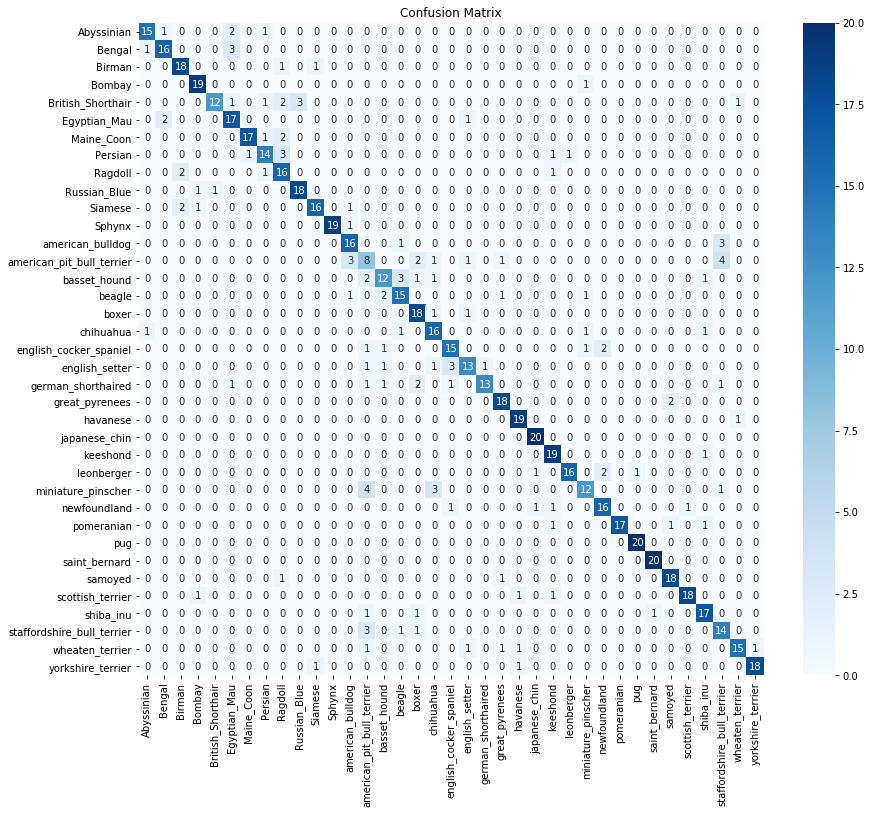

In [115]:
iu.plot_conf_mtx_multiclass(y_revised_true, y_pred, labels)

In [228]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto', sparse=False)
num_classes = len(labels)

y_true_ohe = enc.fit_transform(y_revised_true.reshape(-1, 1))
y_pred_ohe = enc.fit_transform(y_pred.reshape(-1,1))

y_pred_str = [idx_to_class[int(score)] for score in y_pred]

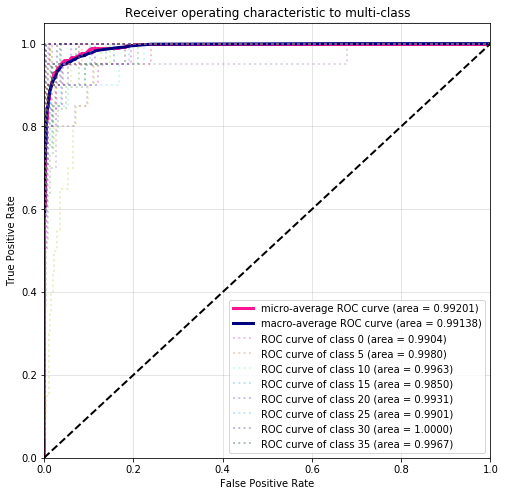

In [293]:
iu.plot_roc_curve_multiclass(y_true_ohe, y_score, num_classes, color_table)

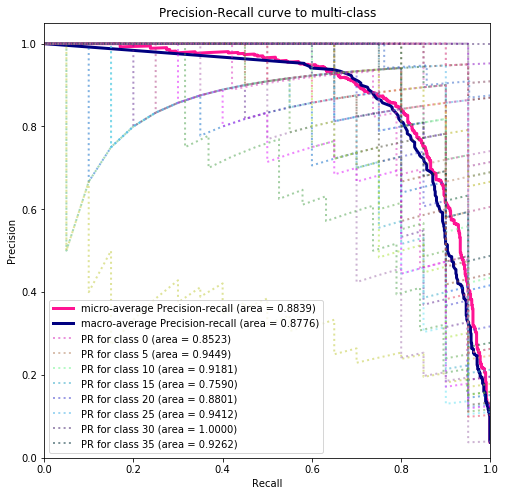

In [294]:
iu.plot_pr_curve_multiclass(y_true_ohe, y_score, num_classes, color_table)